In [29]:
import glob
import pickle

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
from autocorrect import Speller
from nilearn import datasets
from nilearn import plotting
from nilearn.image import resample_img
from nilearn.masking import apply_mask
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import MultiLabelBinarizer

import TextCleanerHelper as helper

spell = Speller(lang='en')

In this notebook I implement a sample analysis examining which sets of features measured from a video watching dataset are most similar to the brains representations of the video.  This notebook implements a sample of a whole brain Representational Similarity Analysis (RSA).   RSA compares the similarity between different similarity (or dissimilarity matrices) from features of the video - BERT embeddings of sentence descriptions,  physiological changes during the video (Heart Rate, Electrodermal activity), Affective features (pleasantness, novelty, etc.) Emotion words participants rated after watching the video.

In [38]:
# create data frame from the single video brain representations - with video information to align with other ratings
data_path = '/Users/mcveigh.k/Desktop/BBOE/BBOE_Data/BETAS/FULL_PILOT_001/FirstPass/T1w_video_regressors/*'
data_dict = {'video': [], 'session': [], 'run': [], 'betas': []}
for video_reg_path in glob.glob(data_path):
    beta_info_list = [beta_info.split('-') for
                      beta_info in video_reg_path.split('/')[-1].split('_')]
    video = beta_info_list[0][1]
    session = beta_info_list[2][1]
    run = beta_info_list[3][1]

    data_dict['video'].append(video)
    data_dict['session'].append(session)
    data_dict['run'].append(run)
    data_dict['betas'].append(video_reg_path)

beta_path_dict = pd.DataFrame(data_dict)

# load emotion,appraisal,physio, and situation features

In [6]:
# load BERT description embeddings
with open('../Videos/video_sentence_embeddings.pkl', "rb") as fIn:
    stored_data = pickle.load(fIn)
    stored_names = stored_data['video_name']
    stored_embeddings = stored_data['embeddings']
embedding_df = pd.DataFrame({'video_name': stored_names, 'embeddings': stored_embeddings})
embedding_df = embedding_df.drop_duplicates('video_name')
embedding_df = embedding_df.set_index('video_name')

#load affective features
af_df = pd.read_csv(
    '/Users/mcveigh.k/Desktop/code/Git_Repos/NSF_Brain_Basis/fMRI_Physio/par_001_SessionRatingPhysioLog.csv',
    index_col='video'
)

#reformat names
beta_path_dict['vid_lower'] = [str.lower(beta_vid) for beta_vid in beta_path_dict['video']]
beta_path_dict.set_index('vid_lower', inplace=True)

beta_path_dict = beta_path_dict.join(embedding_df)
beta_path_dict = beta_path_dict.join(af_df, rsuffix='af')

In [8]:
# do some processing on the emotion features - to get them into something resembling an RDM
fl_cols = ['FL_1', 'FL_2', 'FL_3', 'FL_4', 'FL_5']
par_rating = beta_path_dict
unique_words = np.array('nan')
clean_cols_name = []
for fl_col in fl_cols:
    par_rating[fl_col] = par_rating[fl_col].apply(str).apply(lambda x: helper.clean_text(x))
    par_rating[fl_col] = par_rating[fl_col].apply(str).apply(lambda x: helper.text_preprocessing(x))
    par_rating[fl_col] = par_rating[fl_col].apply(str).apply(lambda x: helper.spell(x))
    par_rating[fl_col + 'cleaned'] = par_rating[fl_col].apply(str).apply(lambda x:
                                                                         helper.GetFreelabelSynonyms(x))
    unique_words = np.append(unique_words, par_rating[fl_col + 'cleaned'].unique())
    clean_cols_name.append(fl_col + 'cleaned')

par_rating['combined_cleaned_emotions'] = par_rating[clean_cols_name].apply(lambda row:
                                                                            '_'.join(row.values.astype(str)), axis=1)
par_rating['combined_cleaned_emotions_list'] = par_rating['combined_cleaned_emotions'].apply(lambda x:
                                                                                             [emo_word for emo_word in
                                                                                              x.split('_') if
                                                                                              emo_word != 'nan'])

#convert emotion text data ie ("anger","sad") to a binarized array for each row to allow for creation of RDM
# for each video the array is 1 by N unique emotion
binarizer = MultiLabelBinarizer()
binarized_inputs = binarizer.fit_transform(par_rating['combined_cleaned_emotions_list'].values)
par_rating['multiclass_label'] = list(binarized_inputs)

#remove any trials for which the participant did not endorse any emotions - as this is an analysis about
# emotional experience we assume the brain representations that occur with out emotional experience are not
# useful for our purpose
beta_path_dict = beta_path_dict[beta_path_dict.FL_1cleaned != 'nan']
beta_path_dict = beta_path_dict[beta_path_dict.FL_1cleaned != 'none']

## Create RDMs for video features

In [19]:
def ExtractUpperTriangle(rsm):
    upper_tri_x, upper_tri_y = np.triu_indices_from(rsm, k=1)
    return rsm[upper_tri_x, upper_tri_y]


# load semantic features and create RDM
np_semantic_embedding = np.array([list(semantic_embedding) for semantic_embedding in beta_path_dict['embeddings']])
RSM_Semantic = pairwise_distances(np_semantic_embedding, metric='correlation')
RSM_Semantic_vector = ExtractUpperTriangle(RSM_Semantic)
#create RDM for affective features
beta_path_dict['Novel.1'] = beta_path_dict['Novel'] + .1  #adjust for case where all ratings are the same in a row
af_df = beta_path_dict[[
    'Novel.1',
    'Predictable',
    'Relevant to your values',
    'Safety',
    'Suddenly',
    'cope',
    'exceeded_expectations',
    'intentionally',
    'under_control',
    'understandable',
    'violate_norm']].fillna(method='ffill').values
RSM_AF = pairwise_distances(af_df, metric='correlation')
RSM_AF_vector = ExtractUpperTriangle(RSM_AF)
#create RDM for physio
physio_df = beta_path_dict[['video_period_hp_z',
                            'video_period_n_scr_z']].fillna(method='ffill')
RSM_physio = pairwise_distances(physio_df, metric='correlation')
RSM_physio_vector = ExtractUpperTriangle(RSM_physio)

#create RDM for core affect
val_df = beta_path_dict[['valence_rating', 'arousal_rating']].fillna(value=2)
RSM_valence = pairwise_distances(val_df[['valence_rating', 'arousal_rating']])
RSM_valence_vector = ExtractUpperTriangle(RSM_valence)

#create emotion rdm
emotion_arr = np.array(list(beta_path_dict['multiclass_label'].values))
RSM_emotion = pairwise_distances(emotion_arr, metric='correlation')
RSM_emotion_vector = ExtractUpperTriangle(RSM_emotion)
# load fMRI data and brain mask - parcellating the brain into different areas (visual, auditory, etc.)
beta_imgs = []
for beta_file in beta_path_dict.betas:
    fmri_load = nib.load(beta_file)
    beta_imgs.append(fmri_load)

affine_func, shape_func = fmri_load.affine, fmri_load.shape
dataset_ho = datasets.fetch_atlas_schaefer_2018(n_rois=200)
mask_nib = nib.load(dataset_ho.maps)
#resample brain mask to be in the same dimensions as brain data
resampled_brain_mask = resample_img(mask_nib, affine_func, shape_func[:3], interpolation='nearest')
mask_arr = resampled_brain_mask.get_fdata()
np_betas = np.array(beta_imgs)

# Run RSA for each brain area in parcellation

In [ ]:
brain_stat_sem_save = np.zeros_like(mask_arr)
brain_stat_hr_save = np.zeros_like(mask_arr)
brain_stat_af_save = np.zeros_like(mask_arr)
brain_stat_emo_save = np.zeros_like(mask_arr)

for mask_area_idx in np.unique(mask_arr):
    specific_area_mask = np.isin(mask_arr, [mask_area_idx]) * 1
    nib_mask = nib.Nifti1Image(specific_area_mask, affine=affine_func)
    resampled_imgs = apply_mask(beta_imgs, nib_mask)
    fMRI_values_in_mask = resampled_imgs[:,np.where(resampled_imgs[0] != 0)][:, 0, :]
    RSM_betas = pairwise_distances(fMRI_values_in_mask,metric='correlation')
    RSM_betas_vector = ExtractUpperTriangle(RSM_betas)

    semantic_correlation = np.corrcoef(RSM_betas_vector, RSM_Semantic_vector)[0, 1]
    appraisal_correlation = np.corrcoef(RSM_betas_vector, RSM_AF_vector)[0, 1]
    physio_correlation = np.corrcoef(RSM_betas_vector, RSM_physio_vector)[0, 1]
    valence_correlation = np.corrcoef(RSM_betas_vector, RSM_valence_vector)[0, 1]
    emo_correlation = np.corrcoef(RSM_betas_vector, RSM_emotion_vector)[0, 1]

    brain_stat_sem_save[np.where(specific_area_mask)] = semantic_correlation
    brain_stat_hr_save[np.where(specific_area_mask)] = physio_correlation
    brain_stat_af_save[np.where(specific_area_mask)] = appraisal_correlation
    brain_stat_emo_save[np.where(specific_area_mask)] = emo_correlation

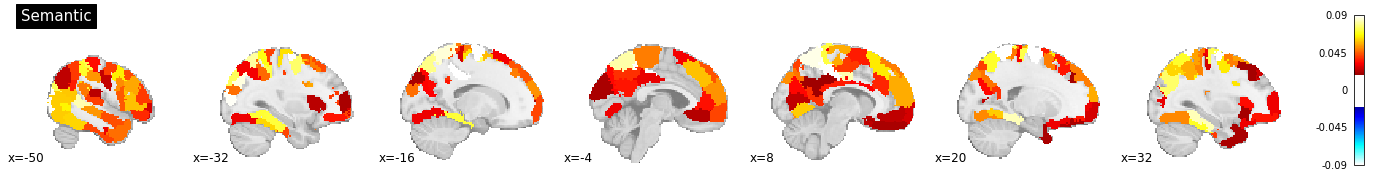

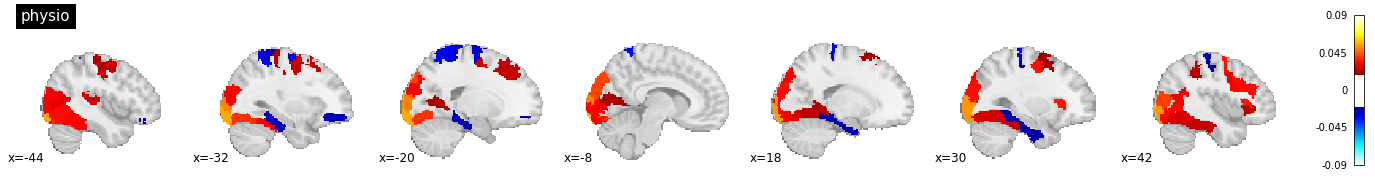

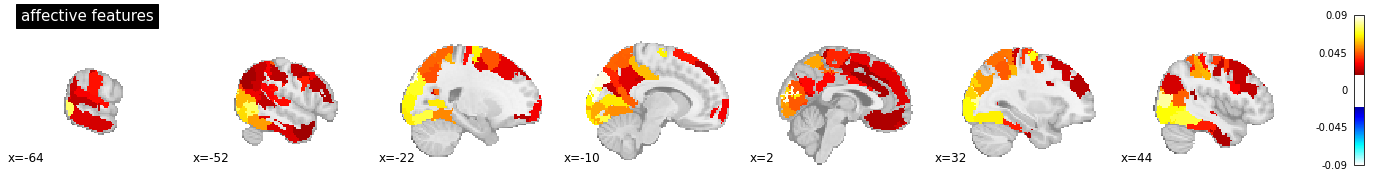

In [37]:
threshold_val = .02
vmax_val = .09
plotting.plot_stat_map(brain_stat_sem_save,
                       display_mode='x',
                       threshold=threshold_val,
                       vmax=vmax_val,
                       title='Semantic',
                       colorbar=True)
plt.show()
plotting.plot_stat_map(brain_stat_hr_save,
                       display_mode='x',
                       threshold=threshold_val,
                       vmax=vmax_val,
                       title='physio',
                       colorbar=True)
plt.show()
plotting.plot_stat_map(brain_stat_af_save,
                       display_mode='x',
                       threshold=threshold_val,
                       vmax=vmax_val,
                       title='affective features',
                       colorbar=True)
plt.show()

## A few thoughts on the results
Of course these results are pretty preliminary but a few things jump out.  First the semantic and affective features are more similar representations to the brain for the vast majority of the regions examined than the physiological correlates.  Second if we look at the posterior half of the brain we see both the semantic and affective features show somewhat similar patterns in that they correlate with brain representations moderately high for this style of analysis.  There are some important differences though.  The semantic represenations do not well correlate with brain representations with early visual areas whereas the affective ratings do.  This is notable as there is a large literature showing affective content of pictures modulating early sensory areas.  Second as we move to higher, association cortices in the posterior areas of the brain such as precuneus or the posterior cingulate cortex we see the opposite pattern.  This is notable as these regions are often though of a involved in semantic processes such as multimodal association, and story building.  That these posterior results concord with the literature gives us a nice sanity check.

A similar sanity check is available for the physiological results. In that we see the anterior insula a region of the brain implicated in physiological regulation correlates most highly with the physio RDM.  Interestingly we see several areas with with significant negative relations with the physio RDM matrix. A possible explanation for these negative associations is these regions may show differentiation in brain representation (ie might represent different objects differently) while the physiological responses are more similar.  This is possible as a large literature shows a relatively stimulus incentive orienting response in physiology, suggesting very different stimuli, may cause a very similar physiological response.  This explanation is plausible as the areas with negative associations between the RDMs are largely in the ventral visual stream associated with representing objects.

Interestingly frontal areas associated with affect and physiological regulation, such as the ventro medial pre frontal cortex, anterior and mid cingulate both seem to have video representations that show associations with the RDMs for affective features and semantic embeddings.  Future analyses should extend the current analysis delineate whether the semantic and affective RDMs explain similar or different variance.
